# Read Data

In [1]:
import numpy as np
import pandas as pd
import json
from collections import OrderedDict, defaultdict,Counter
from pathlib import Path
import os
ROOT = Path('devign')
ROOT.mkdir(exist_ok=True)
data = json.load(open(ROOT/'Devign.json'), object_pairs_hook=OrderedDict)

In [2]:
testIDs = list(map(int,open(os.path.join(ROOT,"test.txt")).readlines()))
trainIDs = list(map(int,open(os.path.join(ROOT,"train.txt")).readlines()))
validIDs = list(map(int,open(os.path.join(ROOT,"valid.txt")).readlines()))
len(testIDs),min(testIDs), min(trainIDs), min(validIDs)

(2732, 3, 0, 8)

In [3]:
details = []
with open('TransformationDetails-TEST.txt', 'r') as f:
    content = f.readlines()
    for row in content:
        details.append(list(row.split()))
len(details)

17199

## Frequency of each method

In [4]:
translateMethod = {'LimitsOfML4Vuln-transformations':'LimitsOfML4Vuln',
                'Code-Imitator-transformations':'Code-Imitator',
                'RoPGen-transformations':'RoPGen'}
tf = {"tf_12":"remove_newline_tabs",
     "tf_4":"insert_unexecuted_code",
      "tf_5":"insert_comment",
      "tf_7":"insert_whitespace",
      "tf_9":"remove_comments"
     }
def getName(method,transform):
    repl = ["_transformations","_1","_2","_3"]
    method = translateMethod[method]
    if "tf" in transform:
        transform = tf[transform]
    if transform == "Definition_and_initialization_of_multiple_variables_with_same_types":
        transform = "Initialization_multiple_variables"
    transform_name = method+"-"+ transform
    for x in repl:
        transform_name = transform_name.replace(x,"")
    return transform_name

transform_names = []
for a,b,c,d in details:
    transform_name = getName(a,b)
    transform_names.append(transform_name)
transformC = Counter(transform_names)
transformC

Counter({'LimitsOfML4Vuln-remove_newline_tabs': 2732,
         'LimitsOfML4Vuln-insert_comment': 2732,
         'LimitsOfML4Vuln-insert_unexecuted_code': 2732,
         'LimitsOfML4Vuln-insert_whitespace': 2732,
         'LimitsOfML4Vuln-remove_comments': 1341,
         'Code-Imitator-Floating-point_type': 17,
         'Code-Imitator-Include-typedef': 701,
         'Code-Imitator-Compound_statement': 3,
         'Code-Imitator-Input_interface': 17,
         'Code-Imitator-Output_interface': 17,
         'RoPGen-Location_and_initializing_local_variables': 1639,
         'RoPGen-Access_of_array_pointer_elements': 3,
         'RoPGen-Variable_assignment': 15,
         'RoPGen-Initialization_multiple_variables': 1697,
         'RoPGen-Compound_if_statements': 513,
         'RoPGen-Loop_structures': 308})

# Read predictions on TEST set

In [5]:
f = open("Results/vulberta-TEST.txt").readlines()
origLabel = dict()
origPrediction = dict()
incorrectPredictionsVulberta = dict()
for i,l in enumerate(f):
    content = l.split()
    origLabel[testIDs[i]] = content[1]
    origPrediction[testIDs[i]] = content[0]
    if origLabel[testIDs[i]] != origPrediction[testIDs[i]]:
        incorrectPredictionsVulberta[testIDs[i]]=origLabel[testIDs[i]]
len(incorrectPredictionsVulberta),len(incorrectPredictionsVulberta)/2732

(964, 0.3528550512445095)

In [6]:
f = open("Results/plbart-TEST.txt").readlines()
origLabel_PLBART = dict()
origPrediction_PLBART = dict()
incorrectPredictionsPLBART = dict()
for i,l in enumerate(f):
    if l.startswith("Accuracy"):break
    content = l.split()
    origLabel_PLBART[testIDs[i]] = content[1]
    origPrediction_PLBART[testIDs[i]] = content[0]
    if origLabel_PLBART[testIDs[i]] != origPrediction_PLBART[testIDs[i]]:
        incorrectPredictionsPLBART[testIDs[i]]=origLabel_PLBART[testIDs[i]]
len(incorrectPredictionsPLBART),len(incorrectPredictionsPLBART)/2732

(1044, 0.3821376281112738)

# Corrective - VULBERTA

In [9]:
f = open("Results/vulberta-transformed-TEST.txt").readlines()
usefulVULBERTA = {k:0 for k in transformC.keys()}
possibleVULBERTA = {k:0 for k in transformC.keys()}
for i,l in enumerate(f):
    content = l.split()
    getID = int(details[i][2])
    if getID not in incorrectPredictionsVulberta:
        continue
    origPred = origPrediction[getID]
    transformName = getName(details[i][0],details[i][1])
    possibleVULBERTA[transformName]+=1
    if str(content[0]) == incorrectPredictionsVulberta[getID]:
        usefulVULBERTA[transformName]+=1

# Corrective - PLBART

In [10]:
f_PLBART = open("Results/plbart-transformed-TEST.txt").readlines()
usefulPLBART = {k:0 for k in transformC.keys()}
possiblePLBART = {k:0 for k in transformC.keys()}
for i,l in enumerate(f_PLBART):
    if l.startswith("Accuracy"):break
    content = l.split()
    getID = int(details[i][2])
    if getID not in incorrectPredictionsPLBART:
        continue
    origPred = origPrediction[getID]
    transformName = getName(details[i][0],details[i][1])
    possiblePLBART[transformName]+=1
    if str(content[0]) == incorrectPredictionsPLBART[getID]:
        usefulPLBART[transformName]+=1

# Make Chart

In [11]:
from matplotlib import pyplot as plt
import seaborn as sns

In [12]:
dataVULBERTA = []
dataPLBART = []
for k in transformC.keys():
    if possibleVULBERTA[k]:
        dataVULBERTA.append(usefulVULBERTA[k]/possibleVULBERTA[k])
    else:
        dataVULBERTA.append(0)
        
    if possiblePLBART[k]:
        dataPLBART.append(usefulPLBART[k]/possiblePLBART[k])
    else:
        dataPLBART.append(0)

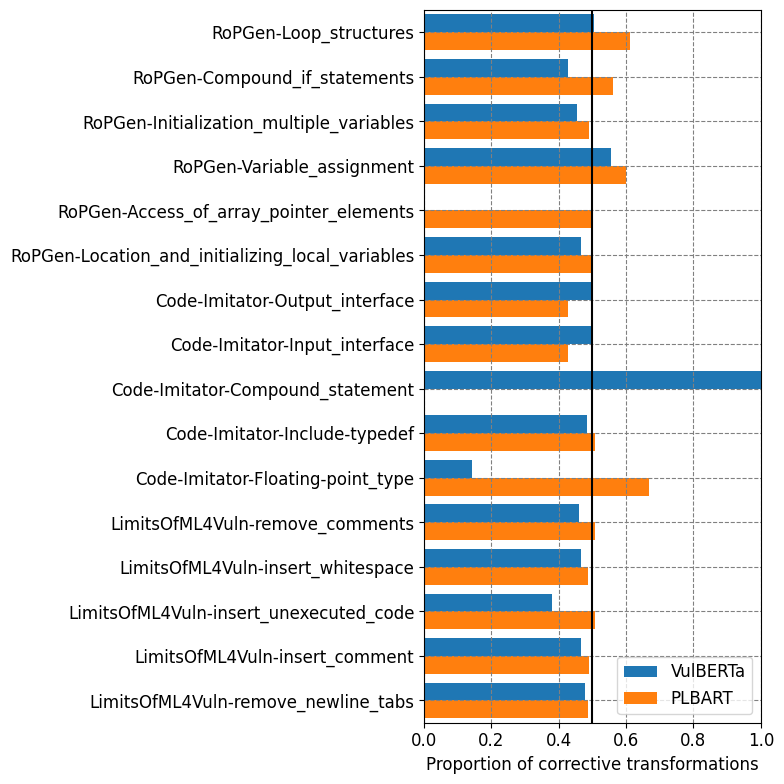

In [13]:
x = np.arange(16) 
width = 0.40
labels = list(transformC.keys())

plt.rcParams.update({'font.size':12})
fig = plt.figure(figsize=(8, 8))

plt.grid(color='gray', linestyle='dashed')
plt.barh(x+0.2, dataVULBERTA, width) 
plt.barh(x-0.2, dataPLBART, width) 
plt.xlim(0,1)
ax = fig.axes[0]
ax.set_yticks(np.arange(len(labels)))
ax.set_yticklabels(labels)
plt.ylim(-0.5, 15.5)
plt.legend(["VulBERTa","PLBART"])
plt.axvline(x=0.5,color="black")
plt.xlabel("Proportion of corrective transformations")
plt.tight_layout()
# plt.savefig("images/corrective.png")
# plt.savefig("images/corrective.pdf")